In [278]:
import pandas as pd
import numpy as np
from pathlib import Path
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from scipy.stats import linregress
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [274]:
results_dir = Path('casp-results')
figure_dir = Path('5-15_figures')

(1308, 7)
target
T1025    0.049357
T1028    0.185957
T1038    0.156162
T1056    0.204152
Name: md_na, dtype: float64
Model R-squared: 0.755199, Adj R-squared: 0.640427, p-value: 1.1263479460959704e-101


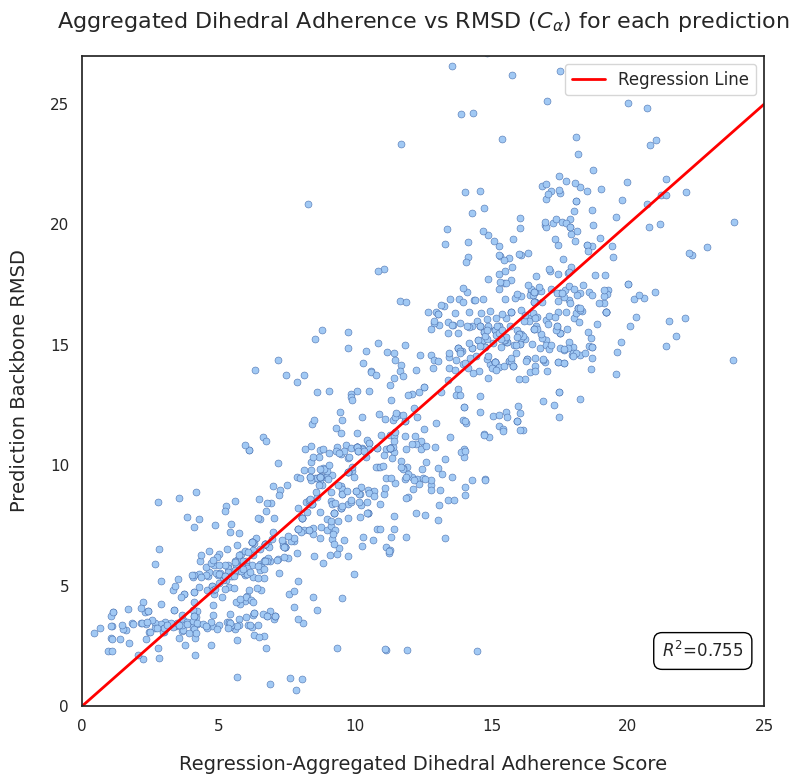

In [296]:
def filter_and_agg(series, agg='sum', quantile=0.8):
    series = series[series < series.quantile(quantile)]
    return series.agg(agg)

def calc_perc_na(series):
    return series.sum() / len(series)

def plot_md_vs_rmsd_for_multiple(rmsd_lim=np.inf, md_lim_low=0, md_lim=np.inf):
    phi_psi_predictions = []
    xray_phi_psi = []
    results = []
    for protein_id in ['T1038', 'T1056', 'T1028', 'T1025']:
        outdir_ = Path(f'tests/{protein_id}_win5-6')
        phi_psi_predictions.append(pd.read_csv(outdir_ / f'phi_psi_predictions_md-kmeans.csv'))
        xray_phi_psi.append(pd.read_csv(outdir_ / f'xray_phi_psi_md-kmeans.csv'))
        results_file = Path(results_dir / f'{protein_id}.txt')
        if not results_file.exists():
            results_file = Path(results_dir / f'{protein_id}-D1.txt')
        results.append(pd.read_csv(results_file, sep='\s+'))
        results[-1] = results[-1][results[-1].columns[1:]]
        results[-1]['Model'] = results[-1]['Model'].apply(lambda x: x.split('-')[0])
    phi_psi_predictions = pd.concat(phi_psi_predictions)
    xray_phi_psi = pd.concat(xray_phi_psi)
    results = pd.concat(results)

    phi_psi_predictions['target'] = phi_psi_predictions.protein_id.apply(lambda x: x[:5])

    phi_psi_predictions['md_na'] = phi_psi_predictions.md.isna()
    group_maha = phi_psi_predictions.groupby('protein_id', as_index=False).agg(
        md=('md',lambda x: filter_and_agg(x, agg='sum', quantile=0.8)),  # not used here
        std_md=('md',lambda x: filter_and_agg(x, agg='std', quantile=0.8)), # not used here
        md_na=('md_na',calc_perc_na),
        target=('target',lambda x: x.iloc[0]),
        mds=('md', list),
        md_len=('md', len)
    )
    print(group_maha.shape)
    print(group_maha.groupby('target').mean(numeric_only=True).md_na)
    group_maha = group_maha.merge(results[['Model', 'RMS_CA']], left_on='protein_id', right_on='Model', how='inner')
    group_maha = group_maha[group_maha.md_na <= group_maha.md_na.quantile(0.75)]
    group_maha = group_maha[(group_maha.RMS_CA < rmsd_lim) & (group_maha.md > md_lim_low) & (group_maha.md < md_lim)].dropna()

    n_comp = 400 #max(group_maha.md_len.values)
    Xs = []
    ys = []
    for target in group_maha.target.unique():
        view = group_maha[group_maha.target == target]
        X = np.array(view.mds.values.tolist())
        y = view.RMS_CA.values

        # X = np.where(np.isnan(X), np.nanmean(X,axis=0), X)
        X[np.isnan(X)] = 0
        X = (X - X.mean(axis=1, keepdims=True)) / X.std(axis=1, keepdims=True)        

        # pad X to n_comp if less
        if X.shape[1] < n_comp:
            X = np.pad(X, ((0,0),(0,n_comp-X.shape[1])), 'constant', constant_values=0)
            
        X = np.sort(X)[:,:n_comp][:,::-1]

        Xs.append(X)
        ys.append(y)

    X = np.concatenate(Xs)
    y = np.concatenate(ys)

    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    group_maha['rms_pred'] = model.predict(X)

    # # for testing
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
    # print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
    # model = sm.OLS(y_train, X_train).fit()
    # y_pred = model.predict(X_train)
    # mse = mean_squared_error(y_train, y_pred)
    # r_squared = r2_score(y_train, y_pred)
    # print(f'Train R-squared: {model.rsquared:.6f}, Adj R-squared: {model.rsquared_adj:.6f}, p-value: {model.f_pvalue}')
    # print(f'Train R-squared: {r_squared:.6f}')
    # print(f'Train MSE: {mse}')
    # y_pred = model.predict(X_test)
    # mse = mean_squared_error(y_test, y_pred)
    # r_squared = r2_score(y_test, y_pred)
    # print(f'Test R-squared: {r_squared:.6f}')
    # print(f'Test MSE: {mse}')

    regr = linregress(group_maha.rms_pred, group_maha.RMS_CA)
    print(f'Model R-squared: {model.rsquared:.6f}, Adj R-squared: {model.rsquared_adj:.6f}, p-value: {model.f_pvalue}')

    sns.set_theme(style="whitegrid")
    sns.set_palette("pastel")
    fig, ax = plt.subplots(figsize=(8, 8))
    
    sns.scatterplot(data=group_maha, x='rms_pred', y='RMS_CA', ax=ax, marker='o', s=25, edgecolor='b', legend=True)
    # sns.regplot(data=group_maha, x='rms_pred', y='RMS_CA', ax=ax, ci=False, scatter=False, color='red', line_kws={'lw':1}, label='Regression Line')
    ax.plot(regr.intercept + regr.slope * np.linspace(0, 30, 100), np.linspace(0, 30, 100), color='red', lw=2, label='Regression Line')
    ax.set_ylim(0, 27)
    ax.set_xlim(0, 25)
    ax.set_xlabel('Regression-Aggregated Dihedral Adherence Score', fontsize=14, labelpad=15)
    ax.set_ylabel('Prediction Backbone RMSD', fontsize=14, labelpad=15)
    ax.set_title(r'Aggregated Dihedral Adherence vs RMSD ($C_{\alpha}$) for each prediction', fontsize=16, pad=20)
    ax.text(0.85, 0.10, r'$R^2$='+f'{model.rsquared:.3f}', transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', edgecolor='black', facecolor='white'))
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.savefig(figure_dir / 'MDvsRMSD.pdf', format='pdf', bbox_inches='tight', dpi=300)
    
    return group_maha
group_maha = plot_md_vs_rmsd_for_multiple();

ANN

In [62]:
import pickle
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [187]:
class Bruh(nn.Module):
    def __init__(self):
        super(Bruh, self).__init__()
        self.c = nn.Conv1d(1, 4, 3, stride=1)
        self.gp = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(4, 1)
    def forward(self, x):
        x = self.c(x)
        x = self.gp(x)
        x = x.squeeze()
        x = self.fc(x)
        return x

In [188]:
for protein_id in ['T1024', 'T1038']:
    X = pickle.load(open(f'./pkls/X-{protein_id}.pkl', 'rb'))
    y = pickle.load(open(f'./pkls/y-{protein_id}.pkl', 'rb'))
    X = torch.tensor(X, dtype=torch.float32).unsqueeze(1)
    y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
    train_dataset = TensorDataset(X, y)
for protein_id in ['T1030', 'T1028']:
    X = pickle.load(open(f'./pkls/X-{protein_id}.pkl', 'rb'))
    y = pickle.load(open(f'./pkls/y-{protein_id}.pkl', 'rb'))
    X = torch.tensor(X, dtype=torch.float32).unsqueeze(1)
    y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
    test_dataset = TensorDataset(X, y)

trainloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [189]:
model = Bruh()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

losses = []
test_losses = []
for epoch in range(25):
    losses_ = []
    for X,y in trainloader:
        y_pred = model(X)
        loss = criterion(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses_.append(loss.item())
    losses.append(sum(losses_) / len(losses_))

    test_losses_ = []
    for X,y in testloader:
        y_pred = model(X)
        loss = criterion(y_pred, y)
        test_losses_.append(loss.item())
    test_losses.append(sum(test_losses_) / len(test_losses_))

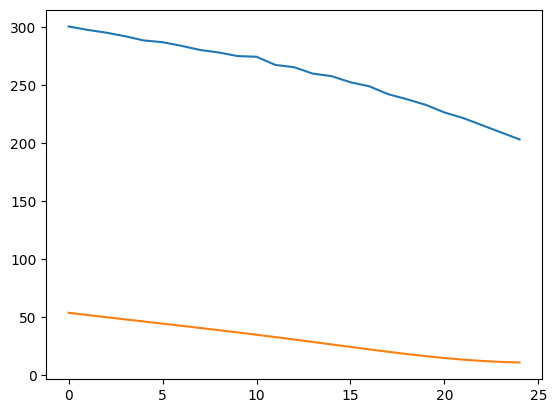

In [190]:
plt.plot(losses[:30])
plt.plot(test_losses[:30])

0.06081319817419232

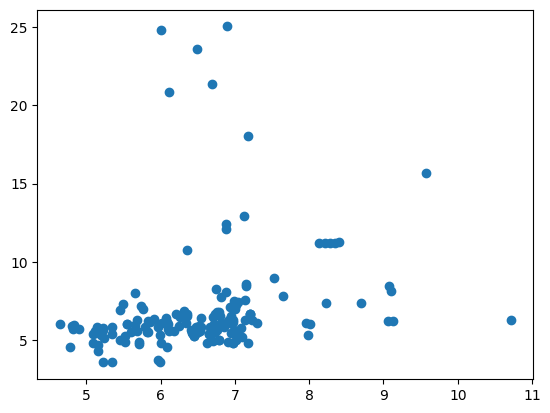

In [194]:
y_pred = model(test_dataset.tensors[0])
plt.scatter(y_pred.detach().numpy(), test_dataset.tensors[1].numpy())
from scipy.stats import linregress
linregress(y_pred.detach().numpy().squeeze(), test_dataset.tensors[1].numpy().squeeze()).rvalue**2